# Probability Distributions for the CGL Elliptic Curve Hash Function using Stochastic Matrices

This interactive notebook allows the user to compute the supersingular isogeny graph over any finite field with characteristic $p$. It then computes the associated stochastic matrix, the eigenvalues of which give us the probability distribution of hash values in the CGL hash function. For more details and background, please read our paper!

If you don't have SageMath or Jupyter downloaded on your computer, the easiest way to use this file is to download it and upload it to your own project on CoCalc, which supports notebooks that run Sage code.

## 1. Functions
This section contains all the functions that implement our algorithms. Below, you can find each function, along with some basic documentation. We recommend that you don't change any of the code that appears in this section.

### 1.a Computing Isogeny Graphs
The following functions implement our algorithm to compute an isogeny graph. Details about this algorithm can be found in Section 3 of our paper. The main function of note here is $\texttt{get_supersingular_hash_graph}$, which takes an elliptic curve defined over a finite field, and returns a graph object, along with other data related to the labelling and coloring of vertices in the graph. The functions $\texttt{add_to_graph}$ and $\texttt{compute_velu}$ are helper functions called by $\texttt{get_supersingular_hash_graph}$.

In [11]:
from sage.rings.finite_rings.hom_finite_field import FiniteFieldHomomorphism_generic

def get_supersingular_hash_graph(start, extend=False, print_in_loop = False, print_outside_loop = True):
    '''This function generates an isogeny graph starting with a supersingular elliptic 
    curve over a finite field. The function also returns two dictionaries edges and 
    edges_back corresponding to that graph, and a dictionary mapping j invariants to node IDs'''
    assert start.is_supersingular()
    F = start.base_field()
    if extend:
        coeffs = start.a_invariants()
        q = F.cardinality()
        F2 = GF(q^(2))
        f = FiniteFieldHomomorphism_generic(Hom(F, F2))
        coeffs = list(map(f, coeffs))
        F = F2
        start = EllipticCurve(F2,coeffs)
    #extend to the field F_{p^2} and redefine E over the new field

    if start.j_invariant() == 0:
        coeffs = [0,-1]
        start = EllipticCurve(F, coeffs)
    if start.j_invariant() == 1728:
        coeffs = [1,0]
        start = EllipticCurve(F, coeffs)
    if print_outside_loop:
        print(start)

    j_dict = {start.j_invariant():(start,0)}
    j_reverse = {0: (start.j_invariant(), start)}
    edges = {0:[]}
    queue = [start]
    counter = 0
    edges_back={}
    #initialize important variables

    while queue != []:
        if print_in_loop:
            print("counter:" + str(counter) +str(queue[0]))
            print("j_inv: " + str(queue[0].j_invariant()))
        add_to_graph(F, edges, j_dict, j_reverse, queue, counter, edges_back, print_in_loop)
        if print_in_loop:
            print()
            print()
        counter += 1
    if print_outside_loop:
        print("Final edges: " + str(edges))
        print("Final edges back: "+str(edges_back))

    G = DiGraph(edges, loops=True)
    if print_outside_loop:
        print("Final j_dict:" + str(j_dict))
    vertex_colors = {}
    if F(0) in j_dict:
        vertex_colors["red"]= [j_dict[F(0)][1]]
    if F(1728) in j_dict:
        vertex_colors["blue"]= [j_dict[F(1728)][1]]
    if len(vertex_colors) == 0:
        vertex_colors = None
    return G, vertex_colors, edges, edges_back, j_reverse


def add_to_graph(F, edges, j_dict, j_reverse, queue, counter, edges_back, print_in_loop):
    '''This function is repeatedly called by get_supersingular_hash_graph to take the 
    most recent curve from nodes, calculate and order its roots, and then call compute_velu'''
    node = queue[0]
    node_j = node.j_invariant()

    if node.j_invariant() == 0:
        coeffs = [0,-1]
        node = EllipticCurve(F, coeffs)
    if node.j_invariant() == 1728:
        coeffs = [1,0]
        node = EllipticCurve(F, coeffs)
        
    queue.remove(queue[0])
    # get the top item from the queue. This is the current node.
    R.<x> = PolynomialRing(F)
    coeffs = node.a_invariants()
    p = x^3+ coeffs[1] * x^2 +coeffs[3]*x+coeffs[4]
    roots = list(map(lambda a:a[0], p.roots(ring=F)))
    roots.sort()
    compute_velu(F, edges, j_dict, j_reverse, counter, queue, roots, node, edges_back, print_in_loop)
    return

def compute_velu(F, edges, j_dict, j_reverse, counter, queue, roots, node, edges_back, print_in_loop):
    '''Takes roots of current node's roots and determines connected j invariants using 
    Velu's formulae. Adds new j invariants to queue and updates edges, edges_back and 
    j_dict accordingly '''
    sub_count = 1 # keeps track of which root in roots we are working on
    node_j = node.j_invariant()
    
    for root in roots:
        point = node([root, 0])
        phi = EllipticCurveIsogeny(node, point)
        E = phi.codomain()
        j = E.j_invariant()
        if j not in j_dict:
            j_dict[j] = (E, 3 * counter + sub_count)
            j_reverse[3 * counter + sub_count] = (j, E)
            edges[j_dict[j][1]] = []
            queue.append(E)
        edges[j_dict[node_j][1]].append(j_dict[j][1])
        if j_dict[j][1] not in edges_back:
            edges_back[j_dict[j][1]]=[]
        edges_back[j_dict[j][1]].append(j_dict[node_j][1])
        sub_count += 1
        if print_in_loop:
            print()
            print("id: "+ str(3*counter+sub_count))
            print("root:"+ str(root))
            print("phi: " + str(phi))
            print("phi dual" +str(phi.dual()))
            print("new_j:"+str(j))
    return

### 1.b Computing Stochastic Matrices
Now that we have our isogeny graph, the following code will help us compute the stochastic matrix describing the graph. For more details about what the stochastic matrix means, see Section 4 of our paper. The function $\texttt{make_stochastic_matrix}$ takes the edge data from our previous functions and computes the associated stochastic matrix. $\texttt{get_sum_eigs}$ computes the normalized eigenvector of the stochastic matrix, and sums together up those entries that have the same current node. The result is the probability distribution for the CGL Hash Function. 

In [2]:
def make_stochastic_matrix(edges, edges_back):
    '''Function that takes a dictionary (edges) mapping each node (by j invariant) to
    each node that it points to in the graph, and a dictionary (edges_back) mapping each
    node to each node that points to it in the graph and returns a stochastic matrix 
    where rows and columns are possible current/previous node pairs for the CGL hash 
    function on the given isogeny graph'''
    l = {}
    i = 0
    range_dict = {}
    counter = 0
    for node in edges_back:
        back = list(set(edges_back[node]))
        range_dict[node] = (counter, counter + len(back))
        counter += len(back)
        for j in range(len(back)):
            l[(node, back[j])] = i
            i += 1
    n = len(l)
    list_to = {}
    stomat = [[0 for i in range(n)] for i in range(n)]
    i = 0
    for pair in l:
        to=edges[pair[0]].copy()
        if len(to) > 1:
            to.remove(pair[1])
        to=list(set(to))
        list_to[i] = [([j,pair[0]],l[(j,pair[0])]) for j in to]
        for j in to:
            stomat[l[(j,pair[0])]][i] = 1/len(to)

        i += 1
    return matrix(stomat), range_dict, l


def get_sum_eigs(stomat, range_dict): 
    eig=stomat.eigenvectors_right()[0]
    eig_sum_dict = {}
    vec = eig[1][0]/sum(eig[1][0])

    for node in range_dict:
         eig_sum_dict[node] = sum(vec[range_dict[node][0]:range_dict[node][1]])
    return eig_sum_dict, vec

### 1.c The CGL Hash Function
The following code implements the CGL hash function in two different ways. The first method uses the algorithm described in the original paper by Charles, Goren and Lauter. This algorithm explicitly computes the isogenies involved at each step. The first method is implemented in the function $\texttt{CGL Hash}$, which uses $\texttt{compute_velu_for_hash}$ as a helper function.

The second method, implemented in $\texttt{CGL_hash_from_graph}$ takes in a precomputed isogeny graph and traces a path through the graph in order to compute the hash value. This method saves on computation time by only computing the isogenies once, instead of re-doing it each time the hash function is called.

In [3]:
def CGL_hash(E,P,bitstring):
    '''This function takes an elliptic curve with starting point and a bitstring and 
    computes the CGL hash value of the bitstring. The function then returns the j invariant
    of the final curve (hash value of the bitstring)'''
    assert 2*P==0
    if bitstring == "":
        return E.j_invariant()
    bit = int(bitstring[0])
    F.<x>=PolynomialRing(E.base_field())
    p = E.a_invariants()[3:]
    p= x^3+p[0]*x+p[1]
    roots = list(map(lambda a:a[0], p.roots(ring=F)))
    roots.remove(P[0])
    if roots[1] < roots[0]:
        roots2 = [roots[1],roots[0]]
        roots = roots2
    E2, P2 = compute_velu_for_hash(E,roots,bit)
    return CGL_hash(E2, P2, bitstring[1:])


def compute_velu_for_hash(E, roots, bit):
    '''Function called by CGL_hash() to compute isogenies for the hash function'''
    point = E([roots[bit],0])
    phi = EllipticCurveIsogeny(E,point)
    point = phi(E([roots[1-bit],0]))
    E = phi.codomain()
    return E, point

def CGL_hash_from_graph(edges, node, prev, bitstring, j_reverse):
    '''Uses a dictionary edges of each node in an isogeny graph mapped to all nodes 
    pointed to by that node to compute the CGL hash function without calculating any
    (more) isogenies. Returns the j invariant (hash value) of the input bitstring'''
    if bitstring == "":
        return j_reverse[node][0]
    bit = int(bitstring[0])
    following = edges[node].copy()
    following.remove(prev)
    return CGL_hash_from_graph(edges, following[bit], node, bitstring[1:], j_reverse)


### 1.d Finding Supersingular Elliptic Curves
In order to use the above code, we need to be able to actually find a supersingular curve over our finite field with characteristic $p$. The following function $\texttt{find_supersingular_curve}$ takes in the prime $p$, and returns a supersingular curve that we can use as an input for our other functions.

In [4]:
def find_supersingular_curve(p):
    '''This function finds a supersingular elliptic curve over a finite field with
    characteristic p by trying each j invariant until one is supersingular. The 
    function then returns that supersingular elliptic curve'''
    assert p.is_prime()
    F.<z>=GF(p^2)
    if mod(p,3)==2:
        return EllipticCurve(F,[0,F(-4)])
    elif mod(p,4)==4:
        return EllipticCurve(F,[F(-4),0])
    else:
        for j in F:
            try:
                a = F(3*j/(1728-j))
                b = F(2*j/(1728-j))
                E=EllipticCurve(F,[a,b])
                if E.is_supersingular():
                    return E
            except:
                continue

## 2. Using The Code
This is the part where you, the user, get to use the above code! In the next block, choose a prime $p > 3$ and a bitstring $b$. You can also declare whether you want to print the results $\texttt{print_tf}$ or if you want to print data at every step of the isogeny computation loop $\texttt{print_all}$. If you don't want to choose, you can also use the default values provided below!

In [21]:
# EDIT HERE!!

p = 23 # default = 23
b = "1110101010001" # default = "1110101010001"
print_tf = True # default = True
print_all = False # default = False

Next, the code will use the previous parameter $p$ to generate an isogeny graph. First, it defines a finite field and finds a supersingular elliptic curve. It then compute the graph object.

In [22]:
F.<z> = GF(p^2)
E = find_supersingular_curve(p)
G, vertex_colors, edges, edges_back, j_reverse = get_supersingular_hash_graph(E, print_in_loop=print_all,print_outside_loop=print_tf)
if print_tf:
    print(vertex_colors)
    print("number of nodes: " + str(len(j_reverse)))

Elliptic Curve defined by y^2 = x^3 + (13*z+125)*x + (73*z+19) over Finite Field in z of size 193^2
Final edges: {0: [1, 2, 3], 1: [4, 0, 6], 2: [7, 7, 0], 3: [0, 11, 12], 4: [13, 14, 1], 6: [16, 1, 18], 7: [2, 12, 2], 11: [22, 3, 18], 12: [7, 3, 27], 13: [4, 29, 18], 14: [27, 4, 29], 16: [22, 6, 27], 18: [13, 11, 6], 22: [16, 29, 11], 27: [12, 14, 16], 29: [13, 22, 14]}
Final edges back: {1: [0, 4, 6], 2: [0, 7, 7], 3: [0, 11, 12], 4: [1, 13, 14], 0: [1, 2, 3], 6: [1, 16, 18], 7: [2, 2, 12], 11: [3, 18, 22], 12: [3, 7, 27], 13: [4, 18, 29], 14: [4, 27, 29], 16: [6, 22, 27], 18: [6, 11, 13], 22: [11, 16, 29], 27: [12, 14, 16], 29: [13, 14, 22]}
Final j_dict:{127*z + 113: (Elliptic Curve defined by y^2 = x^3 + (13*z+125)*x + (73*z+19) over Finite Field in z of size 193^2, 0), 51*z + 15: (Elliptic Curve defined by y^2 = x^3 + (150*z+112)*x + (61*z+76) over Finite Field in z of size 193^2, 1), 168*z + 35: (Elliptic Curve defined by y^2 = x^3 + (5*z+56)*x + (183*z+48) over Finite Field in 

Typically, vertices in a supersingular isogeny graph are labelled with the $j$-invariant. However, sometimes, the $j$-invariant is long and messy, and clutters up the graph, in which case we instead display the graph where vertices are labelled with ID numbers. When using ID numbers, a dictionary showing which ID number corresponds to which curve is also printed. You can choose which option you like below:

In [24]:
# EDIT HERE
use_ID = False #default= True

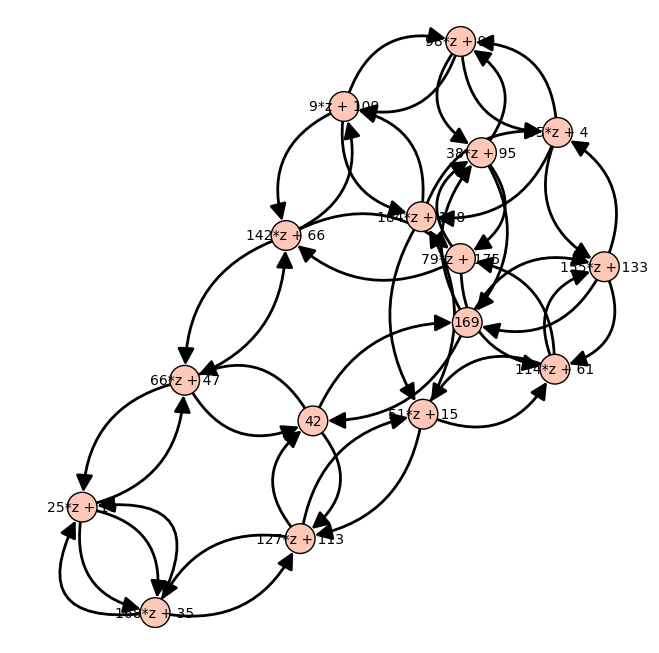

In [25]:
if use_ID:
    G.plot(vertex_colors = vertex_colors,vertex_size=100).show(figsize=15)
    pretty_print(j_reverse)
else:
    edges_j = {}
    for node in edges:
        edges_j[j_reverse[node][0]] = [j_reverse[a][0] for a in edges[node]]
    if vertex_colors != None:
        vertex_colors_j = {}
        for color in vertex_colors:
            vertex_colors_j[color] = [j_reverse[a][0] for a in vertex_colors[color]]
    else:
        vertex_colors_j = None
    G_j = DiGraph(edges_j, loops=True)
    # Use this for j inv labeling
    G_j.plot(vertex_colors = vertex_colors_j,vertex_size=100).show(figsize=10)

The next block of code makes a stochastic matrix based on the isogeny graph generated above and finds the probability of each node.

In [26]:
# This code generates a stochastic matrix from edges and edges back (dictionaries from previous cell)
# Then prints the asymptotic probabilities of the CGL hash function on the input isogeny graph (also generated above)

stomat, range_dict, l= make_stochastic_matrix(edges, edges_back)
eig_sum_dict, vec = get_sum_eigs(stomat, range_dict)
eig_sum_dict2 = {j_reverse[node][0]: eig_sum_dict[node] for node in eig_sum_dict}
if print_tf:
    pretty_print("stomat: ", end="")
    pretty_print(stomat)
    eig_zip_dict = {pair[0]:pair[1] for pair in zip([(j_reverse[p[0]][0], j_reverse[p[1]][0]) for p in l], vec)}
    pretty_print("eigenvector: ")
    pretty_print(eig_zip_dict)
    pretty_print("eig_sum_dict: ")
    pretty_print(eig_sum_dict2)

'stomat: '

46 x 46 dense matrix over Rational Field (use the '.str()' method to see the entries)

'eigenvector: '

{(51*z + 15, 127*z + 113): 1/48,
 (51*z + 15, 184*z + 118): 1/48,
 (51*z + 15, 114*z + 61): 1/48,
 (168*z + 35, 127*z + 113): 1/48,
 (168*z + 35, 25*z + 10): 1/24,
 (42, 127*z + 113): 1/48,
 (42, 169): 1/48,
 (42, 66*z + 47): 1/48,
 (184*z + 118, 51*z + 15): 1/48,
 (184*z + 118, 95*z + 4): 1/48,
 (184*z + 118, 9*z + 109): 1/48,
 (127*z + 113, 51*z + 15): 1/48,
 (127*z + 113, 168*z + 35): 1/48,
 (127*z + 113, 42): 1/48,
 (114*z + 61, 79*z + 175): 1/48,
 (114*z + 61, 51*z + 15): 1/48,
 (114*z + 61, 155*z + 133): 1/48,
 (25*z + 10, 168*z + 35): 1/24,
 (25*z + 10, 66*z + 47): 1/48,
 (169, 155*z + 133): 1/48,
 (169, 42): 1/48,
 (169, 38*z + 95): 1/48,
 (66*z + 47, 142*z + 66): 1/48,
 (66*z + 47, 42): 1/48,
 (66*z + 47, 25*z + 10): 1/48,
 (95*z + 4, 155*z + 133): 1/48,
 (95*z + 4, 184*z + 118): 1/48,
 (95*z + 4, 98*z + 99): 1/48,
 (9*z + 109, 142*z + 66): 1/48,
 (9*z + 109, 184*z + 118): 1/48,
 (9*z + 109, 98*z + 99): 1/48,
 (79*z + 175, 142*z + 66): 1/48,
 (79*z + 175, 114*z + 61): 1/48,
 (79*z + 175, 38*z + 95): 1/48,
 (155*z + 133, 169): 1/48,
 (155*z + 133, 95*z + 4): 1/48,
 (155*z + 133, 114*z + 61): 1/48,
 (38*z + 95, 79*z + 175): 1/48,
 (38*z + 95, 169): 1/48,
 (38*z + 95, 98*z + 99): 1/48,
 (142*z + 66, 79*z + 175): 1/48,
 (142*z + 66, 66*z + 47): 1/48,
 (142*z + 66, 9*z + 109): 1/48,
 (98*z + 99, 95*z + 4): 1/48,
 (98*z + 99, 9*z + 109): 1/48,
 (98*z + 99, 38*z + 95): 1/48}

'eig_sum_dict: '

{51*z + 15: 1/16,
 168*z + 35: 1/16,
 42: 1/16,
 184*z + 118: 1/16,
 127*z + 113: 1/16,
 114*z + 61: 1/16,
 25*z + 10: 1/16,
 169: 1/16,
 66*z + 47: 1/16,
 95*z + 4: 1/16,
 9*z + 109: 1/16,
 79*z + 175: 1/16,
 155*z + 133: 1/16,
 38*z + 95: 1/16,
 142*z + 66: 1/16,
 98*z + 99: 1/16}

The final block of code calculates the CGL hash value of the previously input bitstring $b$ and prints the resulting $j$-invariant.

In [10]:
print(CGL_hash_from_graph(edges, 0, 1, b, j_reverse))

8
